In [1]:
import pandas as pd

df1 = pd.read_csv('bankloanData.csv')
df1.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,preddef1,preddef2,preddef3
0,41,3,17,12,176,9.3,11.359392,5.008608,1,0.808394,0.788640,0.213043
1,27,1,10,6,31,17.3,1.362202,4.000798,0,0.198297,0.128445,0.436903
2,40,1,15,14,55,5.5,0.856075,2.168925,0,0.010036,0.002987,0.141023
3,41,1,15,14,120,2.9,2.658720,0.821280,0,0.022138,0.010273,0.104422
4,24,2,2,0,28,17.3,1.787436,3.056564,1,0.781588,0.737885,0.436903


In [2]:
import numpy as np

# Make a numpy array from the dataframe, except remove rows with no value for 'default'
i = list(df1.columns.values).index('default')
data = np.array([x for x in df1.values if x[i] in ['0', '1']])

# Remove the columns for preddef1, predef2 and preddef3
data = np.delete(data, slice(9,12), axis=1)

# Separate the 'predictors' (aka 'features') from the dependent variable (aka 'label') 
# that we will learn how to predict
predictors = np.delete(data, 8, axis=1)
dependent = np.delete(data, slice(0, 8), axis=1)

In [3]:
# Convert the label type to numeric categorical representing the classes to predict (binary classfier)
dependent = dependent.astype(int)

# And flatten it to one dimensional for use as the expected output label vector in TensorFlow
dependent = dependent.flatten()

# Convert all the predictors to float to simplify this demo TensorFlow code
predictors = predictors.astype(float)

# Get the shape of the predictors
m, n = predictors.shape
m, n

(700, 8)

In [4]:
# Partition the input data into a training set and a test set

m_train = 500
m_test = m - m_train

predictors_train = predictors[:m_train]
dependent_train = dependent[:m_train]

predictors_test = predictors[m_train:]
dependent_test = dependent[m_train:]

# Gets a batch of the training data. 
# NOTE: Rather than loading a whole large data set as above and then taking array slices as done here, 
#       This method can connect to a data source and select just the batch needed.
def get_training_batch(batch_num, batch_size):
    lower = batch_num * (m_train // batch_size)
    upper = lower + batch_size
    return predictors_train[lower:upper], dependent_train[lower:upper]

In [5]:
import tensorflow as tf

# Make this notebook's output stable across runs
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

# A method to build a new neural net layer of a given size,  
# fully connect it to a given preceding layer X, and 
# compute its output Z either with or without (default) an activation function
# Call with activation=tf.nn.relu or tf.nn.sigmoid or tf.nn.tanh, for examples

def make_nn_layer(layer_name, layer_size, X, activation=None):
    with tf.name_scope(layer_name):
        X_size = int(X.get_shape()[1])
        SD = 2 / np.sqrt(X_size)
        weights = tf.truncated_normal((X_size, layer_size), dtype=tf.float64, stddev=SD)
        W = tf.Variable(weights, name='weights')
        b = tf.Variable(tf.zeros([layer_size], dtype=tf.float64), name='biases')
        Z = tf.matmul(X, W) + b
        #Z = tf.add(tf.matmul(X, W), b, name=layer_name)
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [6]:
# Make the neural net structure

n_inputs = n
n_hidden1 = n 
### n_hidden2 = n // 2
n_outputs = 2   # Two output classes: defaulting or non-defaulting on loan

X = tf.placeholder(tf.float64, shape=(None, n_inputs), name='X')

with tf.name_scope('nn'):
    hidden1 = make_nn_layer('hidden1', n_hidden1, X, activation=tf.nn.relu)
    hidden2 = hidden1
    ### hidden2 = make_nn_layer('hidden2', n_hidden2, hidden1, activation=tf.nn.relu)
    outputs = make_nn_layer('outputs', n_outputs, hidden2) 
    outputs = tf.identity(outputs, "nn_output")
    
y = tf.placeholder(tf.int64, shape=(None), name='y')

In [7]:
# Define how the neural net will learn

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=outputs)
    loss = tf.reduce_mean(xentropy, name='l')
    
learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("test"):
    correct = tf.nn.in_top_k(tf.cast(outputs, tf.float32), y, 1)
    accuracy = tf.identity(tf.reduce_mean(tf.cast(correct, tf.float32)), "accuracy")    

In [8]:
# Make a subdirectory in which to save the model (only need to run this once)
!mkdir "../datasets/Neural Net2"

In [9]:
# We're going to model training disruption by manually doing half the 
# training in this cell, and then in the next cell we'll use a 
# new session, pick up where we left off, and ultimately get the
# same answers as in cell [9].
# Start by running cells [1] to [8], and then jump here rather than
# doing cell [9]. (Run the mkdir above, if first time)

# Set up the ability to save and restore the trained neural net
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# This is how many times to use the full set of training data
# n_epochs = 3000
n_epochs = 1500

# For a larger training set, it's typically necessary to break training into
# batches so only the memory needed to store one batch of training data is used
batch_size = 50

with tf.Session() as training_session:
    init.run()
    
    for epoch in range(n_epochs):
        
        # Shuffling (across batches) is feasible for small data sets and
        # helps increase accuracy of models trained with them
        training_set = [[pt_elem, dependent_train[i]] for i, pt_elem in enumerate(predictors_train)]
        np.random.shuffle(training_set)
        predictors_train = [ts_elem[0] for ts_elem in training_set]
        dependent_train = [ts_elem[1] for ts_elem in training_set]
        
        # Loop through the whole training set in batches
        for batch_num in range(m_train // batch_size):
            X_batch, y_batch = get_training_batch(batch_num, batch_size)
            training_session.run(training_op, feed_dict={X: X_batch, y: y_batch})

        if epoch % 100 == 99:
            acc_train = accuracy.eval(feed_dict={X: predictors_train, y: dependent_train})
            acc_test = accuracy.eval(feed_dict={X: predictors_test, y: dependent_test})
            print(epoch+1, "Training accuracy:", acc_train, "Testing accuracy:", acc_test)
            
        if (epoch % 500) == 499:
            save_path = saver.save(training_session, "../datasets/Neural Net2/Neural Net.ckpt", global_step=epoch+1)
            print(epoch+1, " training progress saved to ", save_path)

(100, 'Training accuracy:', 0.75999999, 'Testing accuracy:', 0.755)
(200, 'Training accuracy:', 0.77399999, 'Testing accuracy:', 0.79000002)
(300, 'Training accuracy:', 0.79799998, 'Testing accuracy:', 0.81999999)
(400, 'Training accuracy:', 0.79799998, 'Testing accuracy:', 0.83499998)
(500, 'Training accuracy:', 0.80800003, 'Testing accuracy:', 0.82499999)
(500, ' training progress saved to ', '../datasets/Neural Net2/Neural Net.ckpt-500')
(600, 'Training accuracy:', 0.796, 'Testing accuracy:', 0.815)
(700, 'Training accuracy:', 0.80199999, 'Testing accuracy:', 0.81)
(800, 'Training accuracy:', 0.78799999, 'Testing accuracy:', 0.815)
(900, 'Training accuracy:', 0.81, 'Testing accuracy:', 0.815)
(1000, 'Training accuracy:', 0.81999999, 'Testing accuracy:', 0.81)
(1000, ' training progress saved to ', '../datasets/Neural Net2/Neural Net.ckpt-1000')
(1100, 'Training accuracy:', 0.81800002, 'Testing accuracy:', 0.81)
(1200, 'Training accuracy:', 0.80599999, 'Testing accuracy:', 0.80500001

In [10]:
# IT IS NOT NECESSARY, BUT YOU CAN RESTART THE KERNEL NOW, THEN RUN CELLS [1] through [4], 
# THEN RUN THIS CELL.
# THE ONLY DIFFERENCE IS THAT THE RANDOM NUMBER GENERATORS WILL NOT BE PRESERVED, SO
# ACCURACY WILL COME OUT SLIGHTLY DIFFERENTLY DUE TO DIFFERENCES IN BATCH RANDOMIZATION

import tensorflow as tf_training2

# Make this notebook's randomization consisoutput stable across runs
tf_training2.reset_default_graph()

# This is how many times to use the full set of training data
n_epochs = 3000

# For a larger training set, it's typically necessary to break training into
# batches so only the memory needed to store one batch of training data is used
batch_size = 50

with tf_training2.Session() as training2_session:
    # Initialize by restoring the model, as we did for inference, except from a specific checkpoint file
    inf_saver = tf_training2.train.import_meta_graph('../datasets/Neural Net2/Neural Net.ckpt-1500.meta')
    inf_saver.restore(training2_session, tf_training2.train.latest_checkpoint('../datasets/Neural Net2/'))
    
    # We have a few more variables to get now that we have to resume training and not just do inference
    # but we use essentially the same methods
    graph = tf_training2.get_default_graph()    
    training2_op = graph.get_operation_by_name("train/GradientDescent")
    X2 = graph.get_tensor_by_name("X:0")
    y2 = graph.get_tensor_by_name("y:0")
    accuracy2 = graph.get_tensor_by_name("test/accuracy:0")
    outputs2 = graph.get_tensor_by_name("nn/nn_output:0")
    
    # And now we make a new saver so we can keep on saving
    saver2 = tf_training2.train.Saver()
    
    for epoch in range(1500, n_epochs):
        
        # Shuffling (across batches) is feasible for small data sets and
        # helps increase accuracy of models trained with them
        training_set = [[pt_elem, dependent_train[i]] for i, pt_elem in enumerate(predictors_train)]
        np.random.shuffle(training_set)
        predictors_train = [ts_elem[0] for ts_elem in training_set]
        dependent_train = [ts_elem[1] for ts_elem in training_set]
        
        # Loop through the whole training set in batches
        for batch_num in range(m_train // batch_size):
            X_batch, y_batch = get_training_batch(batch_num, batch_size)
            training2_session.run(training2_op, feed_dict={X2: X_batch, y2: y_batch})

        if epoch % 100 == 99:
            acc_train = accuracy2.eval(feed_dict={X2: predictors_train, y2: dependent_train})
            acc_test = accuracy2.eval(feed_dict={X2: predictors_test, y2: dependent_test})
            print(epoch+1, "Training accuracy:", acc_train, "Testing accuracy:", acc_test)
            
        if (epoch % 500) == 499:
            save_path = saver2.save(training2_session, "../datasets/Neural Net2/Neural Net.ckpt", global_step=epoch+1)
            print(epoch+1, " training progress saved to ", save_path)

    save_path = saver2.save(training2_session, "../datasets/Neural Net2/Neural Net.ckpt")
    
    # A quick test with the trained model 
    Z = outputs2.eval(feed_dict={X2: predictors_test[:20]})
    dependent_pred = np.argmax(Z, axis=1)
    print("")
    print("Actual classes:   ", dependent_test[:20])  
    print("Predicted classes:", dependent_pred)

INFO:tensorflow:Restoring parameters from ../datasets/Neural Net2/Neural Net.ckpt-1500
(1600, 'Training accuracy:', 0.81599998, 'Testing accuracy:', 0.81)
(1700, 'Training accuracy:', 0.80599999, 'Testing accuracy:', 0.81)
(1800, 'Training accuracy:', 0.82200003, 'Testing accuracy:', 0.82499999)
(1900, 'Training accuracy:', 0.80199999, 'Testing accuracy:', 0.80500001)
(2000, 'Training accuracy:', 0.82999998, 'Testing accuracy:', 0.81999999)
(2000, ' training progress saved to ', '../datasets/Neural Net2/Neural Net.ckpt-2000')
(2100, 'Training accuracy:', 0.81199998, 'Testing accuracy:', 0.81)
(2200, 'Training accuracy:', 0.824, 'Testing accuracy:', 0.82499999)
(2300, 'Training accuracy:', 0.80400002, 'Testing accuracy:', 0.815)
(2400, 'Training accuracy:', 0.81800002, 'Testing accuracy:', 0.815)
(2500, 'Training accuracy:', 0.82800001, 'Testing accuracy:', 0.82499999)
(2500, ' training progress saved to ', '../datasets/Neural Net2/Neural Net.ckpt-2500')
(2600, 'Training accuracy:', 0.8

In [11]:
# Restore the saved model and use it to perform inference on a "received" new set of data

# We will simulate "receiving" the new data by taking a slice of the test set.
#predictors_received = predictors_test[20:40]
predictors_received = predictors_test[:]

import tensorflow as tf_inference

with tf_inference.Session() as inference_session:
    inf_saver = tf_inference.train.import_meta_graph('../datasets/Neural Net2/Neural Net.ckpt.meta')
    inf_saver.restore(inference_session, tf_inference.train.latest_checkpoint('../datasets/Neural Net2/'))
    
    graph = tf_inference.get_default_graph()
    X = graph.get_tensor_by_name("X:0")
    nn_output = graph.get_tensor_by_name("nn/nn_output:0")

    Z = inference_session.run(nn_output, feed_dict={X: predictors_received})
    dependent_pred = np.argmax(Z, axis=1)
    
    dependent_prob = inference_session.run(tf_inference.nn.softmax(nn_output), feed_dict={X: predictors_received})

    confidences = [p[dependent_pred[i]] for i, p in enumerate(dependent_prob)]
    
print("Actual classes:   ", dependent_test[:])
print("Predicted classes:", dependent_pred)
print("")
print("Confidences: ", confidences)
print("")
print("Probabilities: ", dependent_prob)

INFO:tensorflow:Restoring parameters from ../datasets/Neural Net2/Neural Net.ckpt
('Actual classes:   ', array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]))
('Predicted classes:', array([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# send the actual dependent variable classifications for param 1, 
# and the confidences of the true classification for param 2
FPR, TPR, _ = roc_curve(dependent_test, dependent_prob[:, 1])

# Now calculate the area under the confidence ROC curve
# This area is equated with the probability that the classifier will rank 
# a randomly selected defaulter higher than a randomly selected non-defaulter
AUC = auc(FPR, TPR)
AUC

0.85273972602739723

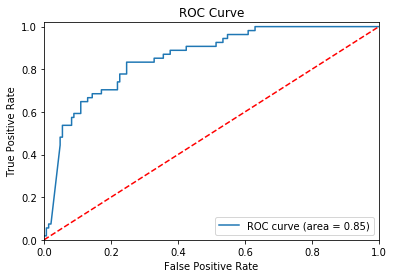

In [13]:
# Plot of the confidence ROC curve 
plt.figure()
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

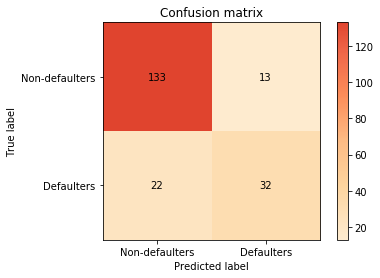

In [14]:
# Install this, if necessary
# !pip install --user --upgrade sklearn_evaluation

from sklearn_evaluation import plot
%matplotlib inline

labels = ["Non-defaulters", "Defaulters"]

plot.confusion_matrix(dependent_test, dependent_pred, target_names=labels)

In [15]:
# dependent_test is the actual classifications
# dependent_prob is the probabilities
# The lowest confidence that can give 100% TPR on the test set is equal to the 
# true class with the lowest confidence, so we'll find that now

defaulter_probs = [dependent_prob[i][1] for i, p in enumerate(dependent_test) if p == 1]
min_conf = np.min(defaulter_probs)
min_conf

0.043730491447763684

In [16]:
# Each non-defaulter with a confidence at or above min_conf would be predicted 
# to be a defaulter (which would be a false positve prediction for a non-defaulter)

non_defaulter_probs = [dependent_prob[i][1] for i, p in enumerate(dependent_test) if p == 0]
false_positives = [x for x in non_defaulter_probs if x >= min_conf]

total = len(defaulter_probs) + len(non_defaulter_probs)
total_correct = total - len(false_positives)
accuracy = float(total_correct) / total

# Overall accuracy would suffer quite a bit, but this achieves 
# the desired high accuracy on true positive identification (defaulters)  
accuracy

0.54

In [17]:
## For when you want to wipe out the training and do it again
#!rm -rf "../datasets/Neural Net"
# Commented out to avoid accidental execution

In [18]:
!ls -l "../datasets/Neural Net2"

total 544
-rw-r--r--  1 boyerj  staff    720 27 Apr 11:47 Neural Net.ckpt-1000.data-00000-of-00001
-rw-r--r--  1 boyerj  staff    238 27 Apr 11:47 Neural Net.ckpt-1000.index
-rw-r--r--  1 boyerj  staff  25821 27 Apr 11:47 Neural Net.ckpt-1000.meta
-rw-r--r--  1 boyerj  staff    720 27 Apr 11:47 Neural Net.ckpt-1500.data-00000-of-00001
-rw-r--r--  1 boyerj  staff    238 27 Apr 11:47 Neural Net.ckpt-1500.index
-rw-r--r--  1 boyerj  staff  25821 27 Apr 11:47 Neural Net.ckpt-1500.meta
-rw-r--r--  1 boyerj  staff    720 27 Apr 11:47 Neural Net.ckpt-2000.data-00000-of-00001
-rw-r--r--  1 boyerj  staff    238 27 Apr 11:47 Neural Net.ckpt-2000.index
-rw-r--r--  1 boyerj  staff  28892 27 Apr 11:47 Neural Net.ckpt-2000.meta
-rw-r--r--  1 boyerj  staff    720 27 Apr 11:47 Neural Net.ckpt-2500.data-00000-of-00001
-rw-r--r--  1 boyerj  staff    238 27 Apr 11:47 Neural Net.ckpt-2500.index
-rw-r--r--  1 boyerj  staff  28892 27 Apr 11:47 Neural Net.ckpt-2500.meta
-rw-r--r--  1 boyerj  staff    720 27 